In [1]:
import os, sys
from os import listdir
from os.path import isfile, isdir, join
from tqdm.notebook import tqdm

In [2]:
import numpy as np
import cv2
from PIL import Image
from typing import Iterable, Dict, Callable

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import utils
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet50
from transformers import get_linear_schedule_with_warmup
from torchsummary import summary
from torcheval.metrics.functional import multiclass_accuracy

In [4]:
import pickle as pkl
from matplotlib import pyplot as plt
%matplotlib inline  
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
BATCH_SIZE = 32
# torch.manual_seed(12345)

In [5]:
def add_gaussian_noise(inp:torch.Tensor, mean:float=0., std_dev:float=1.):
    noise = torch.tensor(np.random.normal(mean, std_dev, inp.size())/255., dtype=torch.float32)
    # print('Noise Min:{}|Max:{}'.format(noise.min(), noise.max()))
    # inp_n = torch.clamp(inp + noise, 0., 1.)
    return inp + noise

def img_to_tensor(img:np.array, 
                mean:np.array=np.array([0.4913997551666284, 0.48215855929893703, 0.4465309133731618]), 
                std_dev:np.array=np.array([0.24703225141799082, 0.24348516474564, 0.26158783926049628])):
    if img.ndim==2:
        img = img[..., None]
    assert img.ndim==3
    if img.shape[-1]==1:
        img = np.repeat(img, repeats=3, axis=2)
    assert img.shape[-1]==3
    img = img[..., ::-1].copy()
    
    compose_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean.astype(float), std_dev.astype(float))
    ])
    img_tensor = compose_tensor(img)
    return img_tensor

def tensor_to_img(inp, shift=False, normalize=False, scale:tuple=None):
    img = inp.permute(1, 2, 0).numpy()
    if scale is not None:
        img[..., 0] = img[..., 0]*scale[1][0]
        img[..., 1] = img[..., 1]*scale[1][1]
        img[..., 2] = img[..., 2]*scale[1][2]
        img[..., 0] = img[..., 0]+scale[0][0]
        img[..., 1] = img[..., 1]+scale[0][1]
        img[..., 2] = img[..., 2]+scale[0][2]
    if shift:
        img[..., 0] = img[..., 0]-img[..., 0].min()
        img[..., 1] = img[..., 1]-img[..., 1].min()
        img[..., 2] = img[..., 2]-img[..., 2].min()
    if normalize:
        img[..., 0] = img[..., 0]/img[..., 0].max()
        img[..., 1] = img[..., 1]/img[..., 1].max()
        img[..., 2] = img[..., 2]/img[..., 2].max()
    img = np.clip(img*255., 0, 255).astype(np.uint8)
    return img

In [6]:
def fourier_transform(image_tensor):
    dft = torch.fft.fft2(image_tensor)
    dft_shifted = torch.fft.fftshift(dft)
    mag = torch.log(torch.abs(dft_shifted)+1.)
    mag_normalized = mag - mag.min()
    mag_normalized /= mag_normalized.max()
    return dft_shifted, mag_normalized

def measure_perturbation(x, nx, l='l2'):
    assert(l in ['l0', 'l1', 'l2', 'linf'])
    diff = torch.mean(nx, dim=0)-torch.mean(x, dim=0)
    if l=='l0':
        measure = torch.sum(diff!=0., dim=None)
    elif l=='l1':
        measure = torch.linalg.matrix_norm(diff, ord=1)
    elif l=='l2':
        # measure = torch.linalg.matrix_norm(diff, ord='fro')
        measure = torch.linalg.matrix_norm(diff, ord=2)
    elif l=='linf':
        measure = torch.abs(diff).max()
    return measure

In [7]:
class image_dataset(CIFAR10):
    def __init__(self, dataset_path = 'C:\\Users\\risha\\Documents\\datasets', 
                split:str='train', sz:int=224, noise_mean:float=0., noise_sigma:float=1.,
                mean:np.array=np.array([0.4913997551666284, 0.48215855929893703, 0.4465309133731618]), 
                std_dev:np.array=np.array([0.24703225141799082, 0.24348516474564, 0.26158783926049628])):
        super(image_dataset, self).__init__(root=dataset_path, train = True if split in ['train', 'val'] else False, download=True)

        self.compose_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((sz, sz))
        ])
        self.normalize_tensor = transforms.Normalize(mean.astype(float), std_dev.astype(float))
        # self.dataset_path = dataset_path
        # self.images_folder = '{}/{}/data'.format(dataset_path, split)
        # self.image_list = [f for f in listdir(self.images_folder) if isfile(join(self.images_folder, f))]
        self.nmean = noise_mean
        self.nstd = noise_sigma

    def __getitem__(self, idx):
        img, label = super(image_dataset, self).__getitem__(idx)
        # img_path = join(self.images_folder, self.image_list[idx])
        # img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x = self.compose_tensor(img)
        nx = add_gaussian_noise(x, self.nmean, self.nstd)
        x = self.normalize_tensor(x)
        nx = self.normalize_tensor(nx)
        return {'original':x, 'perturbed':nx, 'sigma':self.nstd, 
                'l0':measure_perturbation(x, nx, 'l0'),
                'l1':measure_perturbation(x, nx, 'l1'),
                'l2':measure_perturbation(x, nx, 'l2'),
                'linf':measure_perturbation(x, nx, 'linf'),
                'lmean':torch.mean(nx-x),
                'idx':idx, 'ground_label':label
               }

In [8]:
class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: Iterable[str]):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.save_outputs_hook(layer_id))

    def save_outputs_hook(self, layer_id: str) -> Callable:
        def fn(_, input, output):
            self._features[layer_id] = output
        return fn

    def clear_features(self):
        self._features = {layer: torch.empty(0) for layer in layers}

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        _ = self.model(x)
        return self._features

In [9]:
def save_model(model, optimizer, lr_scheduler, epoch, model_path):
    try:
        torch.save({# 'config':vars(config),
                    'epoch':epoch,
                    'state_dict':model.state_dict(),
                    'optimizer':optimizer.state_dict(),
                    'scheduler':lr_scheduler.state_dict()}, model_path)
    except Exception as err:
        print(f"Unexpected {err=}, {type(err)=}")
        return False
    return True

def load_model(model, optimizer, lr_scheduler, model_path, device):
    check_point = torch.load(model_path, map_location=device)
    epoch = check_point['epoch']
    model.load_state_dict(check_point['state_dict'])
    optimizer.load_state_dict(check_point['optimizer'])
    lr_scheduler.load_state_dict(check_point['scheduler'])
    
    # print(check_point['config'])
    # config = Namespace(**check_point['config'])
    
    return model, optimizer, lr_scheduler, epoch

In [10]:
sigmas = np.array([2, 16, 64, 128, 256, 512])
mean=np.array([0.4913997551666284, 0.48215855929893703, 0.4465309133731618])
std_dev=np.array([0.24703225141799082, 0.24348516474564, 0.26158783926049628])
train_split = 0.8

for s in sigmas:
    print(s)
    A = np.ones((256, 256), dtype=np.uint8)*255
    # mean, std_dev = np.zeros((3,), dtype=float), np.ones((3,), dtype=float)
    x = img_to_tensor(A, mean, std_dev)
    x = add_gaussian_noise(x, 0., s)
    print(x.shape, x.dtype)
    print(x.min(), x.max())

    img = tensor_to_img(x, False, False, scale=(mean, std_dev))
    print(img.shape, img.dtype)
    print(img.min(), img.max())
    # cv2.imshow('Noise', img[..., ::-1])
    # cv2.waitKey(1)
# cv2.destroyWindow('Noise')

2
torch.Size([3, 256, 256]) torch.float32
tensor(2.0237) tensor(2.1599)
(256, 256, 3) uint8
252 255
16
torch.Size([3, 256, 256]) torch.float32
tensor(1.7816) tensor(2.3994)
(256, 256, 3) uint8
237 255
64
torch.Size([3, 256, 256]) torch.float32
tensor(1.0061) tensor(3.2786)
(256, 256, 3) uint8
185 255
128
torch.Size([3, 256, 256]) torch.float32
tensor(-0.1080) tensor(4.3459)
(256, 256, 3) uint8
106 255
256
torch.Size([3, 256, 256]) torch.float32
tensor(-2.4374) tensor(6.4686)
(256, 256, 3) uint8
0 255
512
torch.Size([3, 256, 256]) torch.float32
tensor(-6.7069) tensor(10.9156)
(256, 256, 3) uint8
0 255


In [11]:
num_epochs = 100
warmup_frac = 0.2
model_path = './models/sc_resnet50_voc2012_40.pth'

In [12]:
#model definition and load weights
device = torch.device('cuda')
model = resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model.to(device)

/home/ragraw06/UBCO/rishabh/AI_conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ragraw06/UBCO/rishabh/AI_conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
summary(model, (3, 224, 224))
conv_layers = []
for name, layer in model.named_modules():
    if 'conv' in name and isinstance(layer, nn.Conv2d):
        conv_layers.append(name)
print(conv_layers)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [14]:
def seed_worker(worker_id):
    # worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(0)
    random.seed(0)

data_loaders = []
for sigma in sigmas:
    dset = image_dataset(split='test', noise_sigma=sigma)
    train_size = int(train_split * len(dset))
    val_size = len(dset)-train_size
    
    # train_dataset, val_dataset = torch.utils.data.random_split(dset, [train_size, val_size])
    # train_dloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=2)
    # val_dloader = DataLoader(val_dataset, shuffle=True, batch_size=64, num_workers=2)
    g = torch.Generator()
    g.manual_seed(0)
    test_dloader = DataLoader(dset, shuffle=True, batch_size=BATCH_SIZE, worker_init_fn=seed_worker, generator=g)
    # data_loaders.append((train_dloader, val_dloader))
    data_loaders.append((test_dloader,))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [15]:
total_iterations = num_epochs * len(data_loaders[0][0])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
lr_scheduler = get_linear_schedule_with_warmup(optimizer, 
                                               int(warmup_frac*total_iterations), 
                                               total_iterations
                                              ) 
model, optimizer, lr_scheduler, epoch = load_model(model, optimizer, lr_scheduler, model_path, device)
model.eval()
model.to(device)
print(len(data_loaders[0][0]))

313


In [ ]:
sigmas = list(range(50, 500))
global_p_acc_mean = 1.
p_sigma = 1000

for i in range(len(sigmas)):
    attack_key = str(sigmas[i])
    print('Gaussian sigma:', sigmas[i])
    
    temp_dict = {}
    g = torch.Generator()
    g.manual_seed(0)
    dset = image_dataset(split='test', noise_sigma=sigmas[i])
    test_dloader = DataLoader(dset, shuffle=True, batch_size=BATCH_SIZE, worker_init_fn=seed_worker, generator=g)
    o_acc_mean = 0
    p_acc_mean = 0
    
    with torch.no_grad():
        for j, data_dict in enumerate(test_dloader):
            if j==3:
                break
            # oimg = data_dict['original'][0]
            # pimg = data_dict['perturbed'][0]
            # oimg = tensor_to_img(oimg, shift=False, normalize=False, scale=(mean, std_dev))
            # pimg = tensor_to_img(pimg, shift=False, normalize=False, scale=(mean, std_dev))

            o_input = data_dict['original'].to(device)
            o_output = model(o_input)
            o_labels = torch.argmax(F.softmax(o_output.detach(), dim=1), dim=1).cpu()
            # o_output = o_output.cpu().detach().numpy()
            
            p_input = data_dict['perturbed'].to(device)
            p_output = model(p_input)
            p_labels = torch.argmax(F.softmax(p_output.detach(), dim=1), dim=1).cpu()
            # p_output = p_output.cpu().detach().numpy()
            
            ground_labels = data_dict['ground_label']
            # print(o_labels.shape, p_labels.shape,ground_labels.shape)
            o_accuracy = multiclass_accuracy(o_labels, ground_labels, average='micro', num_classes=10)
            p_accuracy = multiclass_accuracy(p_labels, ground_labels, average='micro', num_classes=10)
            # print(o_accuracy, p_accuracy)
            o_acc_mean += o_accuracy
            p_acc_mean += p_accuracy
    o_acc_mean /= 3
    p_acc_mean /= 3
    if p_acc_mean<global_p_acc_mean:
        global_p_acc_mean = p_acc_mean
        p_sigma = sigmas[i]
        print('Attack Sigma:{}| Attack Accuracy:{}'.format(p_sigma, global_p_acc_mean))
    break

In [ ]:
print('Final attack Sigma:{}| attack Accuracy:{}'.format(p_sigma, global_p_acc_mean))

In [16]:
sigmas = [465] #Final attack Sigma:465| attack Accuracy:0.0520833320915699
attack_dict = {str(k):{} for k in sigmas}
attack_dict['original'] = {}
# print(attack_dict)
save_dir = './sc_gaussian'
if not isdir(save_dir):
    os.mkdir(save_dir)

for i in range(len(sigmas)):
    attack_key = str(sigmas[i])
    print('Gaussian sigma:', sigmas[i])
    images_dir = join(save_dir, attack_key)
    if not isdir(images_dir):
        os.mkdir(images_dir)
    
    g = torch.Generator()
    g.manual_seed(0)
    dset = image_dataset(split='test', noise_sigma=sigmas[i])
    test_dloader = DataLoader(dset, shuffle=True, batch_size=BATCH_SIZE, worker_init_fn=seed_worker, generator=g)
    
    with torch.no_grad():
        for j, data_dict in enumerate(tqdm(test_dloader)):
            if j==3:
                break
            # oimg = data_dict['original'][0]
            # pimg = data_dict['perturbed'][0]
            # oimg = tensor_to_img(oimg, shift=False, normalize=False, scale=(mean, std_dev))
            # pimg = tensor_to_img(pimg, shift=False, normalize=False, scale=(mean, std_dev))

            o_input = data_dict['original'].to(device)
            o_output = model(o_input)
            o_labels = torch.argmax(F.softmax(o_output.detach(), dim=1), dim=1).cpu()
            # o_output = o_output.cpu().detach().numpy()
            
            p_input = data_dict['perturbed'].to(device)
            p_output = model(p_input)
            p_labels = torch.argmax(F.softmax(p_output.detach(), dim=1), dim=1).cpu()
            # p_output = p_output.cpu().detach().numpy()
            # ground_labels = data_dict['ground_label']
                
            for k, f_id in enumerate(range(BATCH_SIZE*j,(BATCH_SIZE*j)+o_input.shape[0])):
                f = data_dict['idx'][k].item()
                if i==0:
                    attack_dict['original'][f] = {
                                                    'label':o_labels[k].item()
                                                }
                attack_dict[attack_key][f] = {
                                                'avg':data_dict['lmean'][k].item(),
                                                'l2':data_dict['l2'][k].item(),
                                                'label':p_labels[k].item()
                                            }
                oimg = data_dict['original'][k]
                pimg = data_dict['perturbed'][k]
                nimg = pimg-oimg
                # oimg = tensor_to_img(oimg, shift=False, normalize=False, scale=(mean, std_dev))
                pimg = tensor_to_img(pimg, shift=False, normalize=False, scale=(mean, std_dev))
                nimg = tensor_to_img(nimg, shift=False, normalize=False)
                cv2.imwrite(join(images_dir, '{}.png'.format(f)), pimg[..., ::-1])
                cv2.imwrite(join(images_dir, '{}_noise.png'.format(f)), nimg[..., ::-1])

Gaussian sigma: 465
Files already downloaded and verified


  0%|          | 0/313 [00:00<?, ?it/s]

/home/ragraw06/UBCO/rishabh/AI_conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [17]:
with open('./sc_gaussian.pkl', 'wb') as fp:
    pkl.dump(attack_dict, fp)

In [18]:
extractor = FeatureExtractor(model, conv_layers)
extractor.eval()
extractor.to(device)

FeatureExtractor(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [19]:
sigmas = [465] #Final attack Sigma:465| attack Accuracy:0.0520833320915699
attack_dict = {str(k):{} for k in sigmas}
attack_dict['original'] = {}
# print(attack_dict)
save_dir = './sc_gaussian_features'
if not isdir(save_dir):
    os.mkdir(save_dir)

for i in range(len(sigmas)):
    attack_key = str(sigmas[i])
    print('Gaussian sigma:', sigmas[i])
    images_original_dir = join(save_dir, 'original')
    images_attack_dir = join(save_dir, attack_key)
    if not isdir(images_original_dir):
        os.mkdir(images_original_dir)
    if not isdir(join(images_original_dir, 'src')):
        os.mkdir(join(images_original_dir, 'src'))
    if not isdir(images_attack_dir):
        os.mkdir(images_attack_dir)
    if not isdir(join(images_attack_dir, 'src')):
        os.mkdir(join(images_attack_dir, 'src'))

    g = torch.Generator()
    g.manual_seed(0)
    dset = image_dataset(split='test', noise_sigma=sigmas[i])
    test_dloader = DataLoader(dset, shuffle=True, batch_size=BATCH_SIZE, worker_init_fn=seed_worker, generator=g)
    
    with torch.no_grad():
        for j, data_dict in enumerate(tqdm(test_dloader)):
            if j==3:
                break
                    
            o_input = data_dict['original'].to(device)
            if i==0:
                for b_i in range(o_input.shape[0]):
                #     plt.imshow(tensor_to_img(o_input[b_i].cpu(), False, False, scale=(mean, std_dev)))
                #     plt.show()
                    cv2.imwrite(join(images_original_dir, 'src', '{}.png'.format(data_dict['idx'][b_i])), 
                                tensor_to_img(o_input[b_i].cpu(), False, False, scale=(mean, std_dev))[..., ::-1])
            o_output = extractor(o_input).copy()
            
            p_input = data_dict['perturbed'].to(device)
            for b_i in range(p_input.shape[0]):
            #     plt.imshow(tensor_to_img(p_input[b_i].cpu(), False, False, scale=(mean, std_dev)))
            #     plt.show()
                attack_dict[attack_key][data_dict['idx'][b_i].item()] = {}
                cv2.imwrite(join(images_attack_dir, 'src', '{}.png'.format(data_dict['idx'][b_i])), 
                            tensor_to_img(p_input[b_i].cpu(), False, False, scale=(mean, std_dev))[..., ::-1])
            p_output = extractor(p_input).copy()
            # # print([(k,o_output[k].shape) for k in o_output.keys()])
            # # print([(k,p_output[k].shape) for k in p_output.keys()])
            
            for k in tqdm(p_output.keys()):
                # print(p_output[k].shape)
                if i==0:
                    if not isdir(join(images_original_dir, k)):
                        os.mkdir(join(images_original_dir, k))
                if not isdir(join(images_attack_dir, k)):
                    os.mkdir(join(images_attack_dir, k))
                    
                for b_i in range(p_output[k].shape[0]):
                    if i==0:
                        with open(join(images_original_dir, k, '{}.pkl'.format(data_dict['idx'][b_i])), 'wb') as fp:
                            pkl.dump(o_output[k][b_i].detach().cpu().numpy(), fp)            
                    with open(join(images_attack_dir, k, '{}.pkl'.format(data_dict['idx'][b_i])), 'wb') as fp:
                        pkl.dump(p_output[k][b_i].detach().cpu().numpy(), fp)
                    
                    diff_norm = torch.linalg.matrix_norm(p_output[k][b_i]-o_output[k][b_i], ord=2)
                    attack_dict[attack_key][data_dict['idx'][b_i].item()][k] = np.sqrt(diff_norm.cpu().numpy())
            # break

Gaussian sigma: 465
Files already downloaded and verified


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

In [20]:
with open('./sc_gaussian_features.pkl', 'wb') as fp:
    pkl.dump(attack_dict, fp)

In [21]:
conv_weight_params = []
conv_bias_params = []
for name, param in model.named_parameters():
    if name.split('.')[-1]=='weight' and '.'.join(name.split('.')[:-1]) in conv_layers:
        conv_weight_params.append(name)
    if name.split('.')[-1]=='bias' and '.'.join(name.split('.')[:-1]) in conv_layers:
        conv_bias_params.append(name)
print(len(conv_layers), len(conv_weight_params), len(conv_bias_params))
save_dir = './sc_weights'
if not isdir(save_dir):
    os.mkdir(save_dir)

49 49 0


In [22]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape
    if allkernels:
        tensor = tensor.view(n*c, 1, w, h)
    elif c != 3:
        if ch==-1:
            tensor = torch.mean(tensor, dim=1).unsqueeze(dim=1)
        else:
            tensor = tensor[:, ch, :, :].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow, 64))  
    print(rows, tensor.shape)
    grid = utils.make_grid(tensor, nrow=rows, normalize=True, padding=padding)
    print(grid.shape)
    plt.figure(figsize=(nrow,rows))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    return grid.numpy()

  0%|          | 0/49 [00:00<?, ?it/s]

conv1.weight torch.Size([64, 3, 7, 7])
8 torch.Size([64, 3, 7, 7])
torch.Size([3, 65, 65])
layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
64 torch.Size([4096, 1, 1, 1])
torch.Size([3, 129, 129])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
64 torch.Size([4096, 1, 3, 3])
torch.Size([3, 257, 257])
layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
layer1.2.conv1.weight torch.Size([64, 256, 1, 1])
layer1.2.conv2.weight torch.Size([64, 64, 3, 3])
layer1.2.conv3.weight torch.Size([256, 64, 1, 1])
layer2.0.conv1.weight torch.Size([128, 256, 1, 1])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.conv3.weight torch.Size([512, 128, 1, 1])
layer2.1.conv1.weight torch.Size([128, 512, 1, 1])
layer2.1.conv2.weight torch.Size([128, 128, 3, 3])
layer2.1.conv3.weight torch.Size([512, 128, 1, 1])
layer2.2.conv1.weight torch.Size([128, 512,

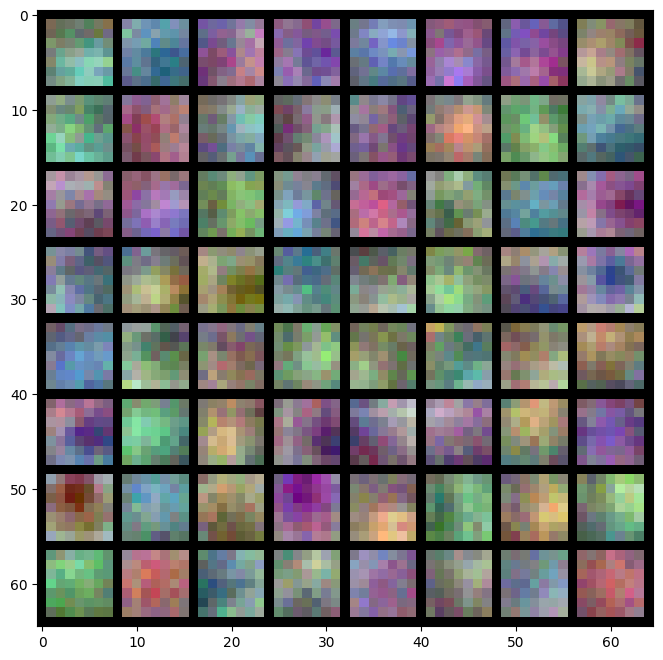

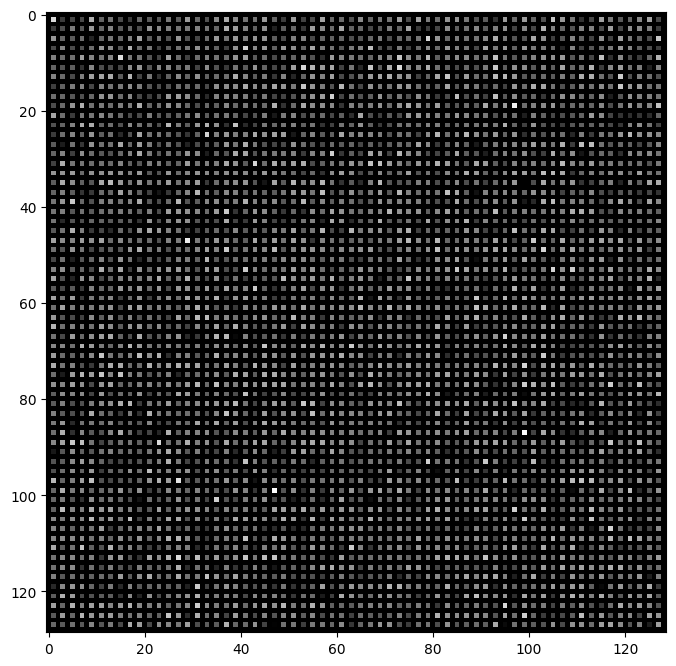

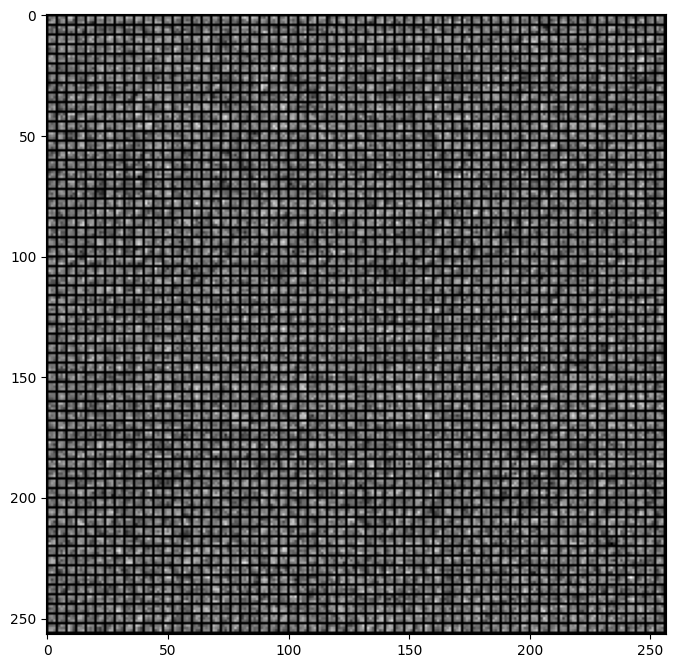

In [25]:
model_param_dict = dict([*model.named_parameters()])
disp_layers = ['conv1.weight', 'layer1.0.conv1.weight', 'layer1.0.conv2.weight']
weight_dict = {}

for weight_key in tqdm(conv_weight_params):
    print(weight_key, model_param_dict[weight_key].data.shape)
    tensor = model_param_dict[weight_key].data.cpu()
    if weight_key==disp_layers[0]:
        grid = visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1)
        grid = np.clip(grid*255, 0, 255).astype(np.uint8)
        cv2.imwrite(join(save_dir, '{}.png'.format(weight_key)), grid.transpose((1, 2, 0))[..., ::-1])
    elif weight_key in disp_layers[1:]:
        grid = visTensor(tensor, ch=0, allkernels=True, nrow=8, padding=1)
        grid = np.clip(grid*255, 0, 255).astype(np.uint8)
        cv2.imwrite(join(save_dir, '{}.png'.format(weight_key)), grid.transpose((1, 2, 0)))
    with open(join(save_dir, '{}.pkl'.format(weight_key)), 'wb') as fp:
        pkl.dump(tensor.numpy(), fp)

    n,c,w,h = tensor.shape
    input = tensor.reshape(n*c, w, h)
    spectral, _ = torch.max(torch.linalg.svdvals(torch.fft.fft2(input)), dim=1)
    # operator_norm = torch.linalg.matrix_norm(input, ord=2)
    operator_norm = np.mean(np.sqrt(spectral.reshape(n, c).cpu().numpy()), axis=1)
    weight_dict[weight_key] = {'spectral':spectral.reshape(n, c, 1), 'operator_norm':operator_norm}

In [26]:
with open('./sc_weights_operator_norm.pkl', 'wb') as fp:
    pkl.dump(weight_dict, fp)